In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('data/clean_listings.csv')

In [4]:
df.head(5)

,Location,Property_Type,Bedrooms,Bathrooms,Size_SQM,Amenities,Price_KES,Listing_Type,Listing_Date,Price_Per_SQM,Amenity_Score,Listing_Month,Distance_to_CBD_KM
0,Acacia,House,1,1,50,"Security, Parking",15000000,For Sale,2025-12-06,3.000000e+05,2,12,10.0
1,Fourways Junction Estate,Apartment,3,2,120,"Security, Parking",70000,For Rent,2026-01-29,5.833333e+02,2,1,10.0
2,A 70,Townhouse,5,5,250,"Security, Parking",68000000,For Sale,2025-12-03,2.720000e+05,2,12,10.0
3,Runda,Townhouse,4,4,180,"Security, Parking",29500000,For Sale,2025-11-28,1.638889e+05,2,11,9.8
4,Kileleshwa,Townhouse,5,5,250,"Security, Parking",350000000,For Sale,2026-02-03,1.400000e+06,2,2,4.2


##### Splitting listing type for separate analysis

In [5]:
sale_df = df[df['Listing_Type'] == 'For Sale'].copy()
rent_df = df[df['Listing_Type'] == 'For Rent'].copy()

print(f"\nFor Sale: {len(sale_df)} listings")
print(f"For Rent: {len(rent_df)} listings")


For Sale: 1840 listings
For Rent: 1837 listings


### Exploratory Analysis

##### Q1. Which locations are most expensive?

In [ ]:
### For sales properties

print("\nMost Expensive Location (For Sale) - Median Price:")
sale_by_location = sale_df.groupby('Location')['Price_KES'].agg(['median', 'count'])
sale_by_location = sale_by_location[sale_by_location['count'] >= 5]
sale_by_location = sale_by_location.sort_values('median', ascending=False)

print("\nTop 10:")
for i, (loc, row) in enumerate(sale_by_location.tail(5).iterrows(), 1):
    print(f"{i:2d}. {loc:20s} - KES {row['median']:>15,.0f} ({int(row['count'])} listings)")


### For rent properties

print("\n\nMost Expensive Locations (For Rent) - Median Monthly Rent:")
rent_by_location = rent_df.groupby('Location')['Price_KES'].agg(['median', 'count'])
rent_by_location = rent_by_location[rent_by_location['count'] >= 5]
rent_by_location = rent_by_location.sort_values('median', ascending=False)

print("\nTop 10:")
for i, (loc, row) in enumerate(rent_by_location.head(10).iterrows(), 1):
    print(f"{i:2d}. {loc:20s} - KES {row['median']:>12,.0f}/month ({int(row['count'])} listings)")


Most Expensive Location (For Sale) - Median Price:

Top 10:
 1. Ongata Rongai        - KES       8,000,000 (23 listings)
 2. Juja                 - KES       7,200,000 (10 listings)
 3. Kitengela            - KES       6,750,000 (62 listings)
 4. Acacia               - KES       6,200,000 (16 listings)
 5. Milimani             - KES       6,200,000 (8 listings)


Most Expensive Locations (For Rent) - Median Monthly Rent:

Top 10:
 1. Parklands Road       - KES      150,000/month (5 listings)
 2. Othaya Road          - KES      150,000/month (7 listings)
 3. Brookside Drive      - KES      142,500/month (10 listings)
 4. Parklands            - KES      140,000/month (84 listings)
 5. Brookside            - KES      140,000/month (29 listings)
 6. Laikipia Road        - KES      130,000/month (9 listings)
 7. Raphta Road          - KES      130,000/month (6 listings)
 8. School Lane          - KES      130,000/month (10 listings)
 9. Riverside            - KES      122,500/month (88 lis

#### Visualizations for the above

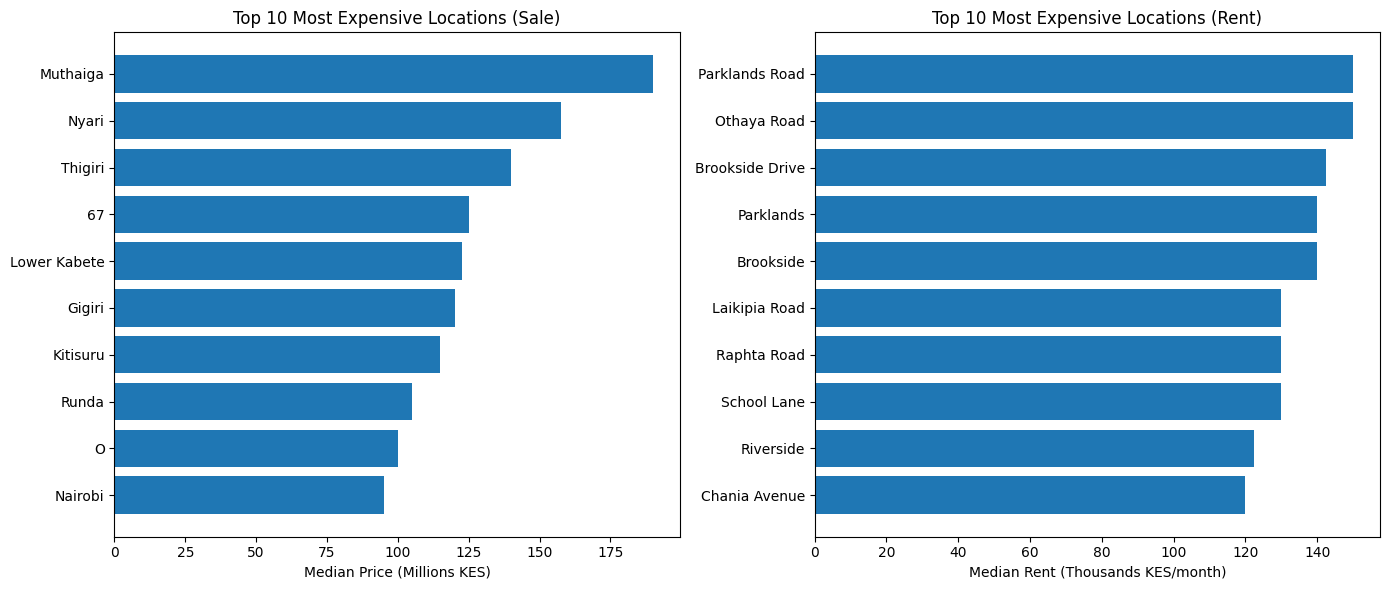

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sale prices by location
top_sale_locs = sale_by_location.head(10)
axes[0].barh(range(len(top_sale_locs)), top_sale_locs['median'] / 1_000_000)
axes[0].set_yticks(range(len(top_sale_locs)))
axes[0].set_yticklabels(top_sale_locs.index)
axes[0].set_xlabel('Median Price (Millions KES)')
axes[0].set_title('Top 10 Most Expensive Locations (Sale)')
axes[0].invert_yaxis()

# Rent prices by location  
top_rent_locs = rent_by_location.head(10)
axes[1].barh(range(len(top_rent_locs)), top_rent_locs['median'] / 1_000)
axes[1].set_yticks(range(len(top_rent_locs)))
axes[1].set_yticklabels(top_rent_locs.index)
axes[1].set_xlabel('Median Rent (Thousands KES/month)')
axes[1].set_title('Top 10 Most Expensive Locations (Rent)')
axes[1].invert_yaxis()

plt.tight_layout()

##### Q2. How strongly does size affect price?

In [ ]:


sale_corr = sale_df[['Size_SQM', 'Price_KES']].corr().iloc[0, 1]
rent_corr = rent_df[['Size_SQM', 'Price_KES']].corr().iloc[0, 1]

print(f"\nCorrelation between Size and Price:")
print(f"  For Sale: {sale_corr:.3f}")
print(f"  For Rent: {rent_corr:.3f}")

if sale_corr > 0.7:
    print("\n  Strong positive relationship for sale properties")
elif sale_corr > 0.4:
    print("\n  Moderate positive relationship for sale properties")
else:
    print("\n  Weak relationship for sale properties")

# Price per sqm analysis
print(f"\nPrice per Square Meter:")
print(f"  Sale - Mean: KES {sale_df['Price_Per_SQM'].mean():,.0f}/m²")
print(f"  Sale - Median: KES {sale_df['Price_Per_SQM'].median():,.0f}/m²")
print(f"  Rent - Mean: KES {rent_df['Price_Per_SQM'].mean():,.0f}/m²")
print(f"  Rent - Median: KES {rent_df['Price_Per_SQM'].median():,.0f}/m²")


Correlation between Size and Price:
  For Sale: 0.493
  For Rent: -0.025

  Moderate positive relationship for sale properties

Price per Square Meter:
  Sale - Mean: KES 288,737/m²
  Sale - Median: KES 213,194/m²
  Rent - Mean: KES 957/m²
  Rent - Median: KES 806/m²


#### Visualizations for the above

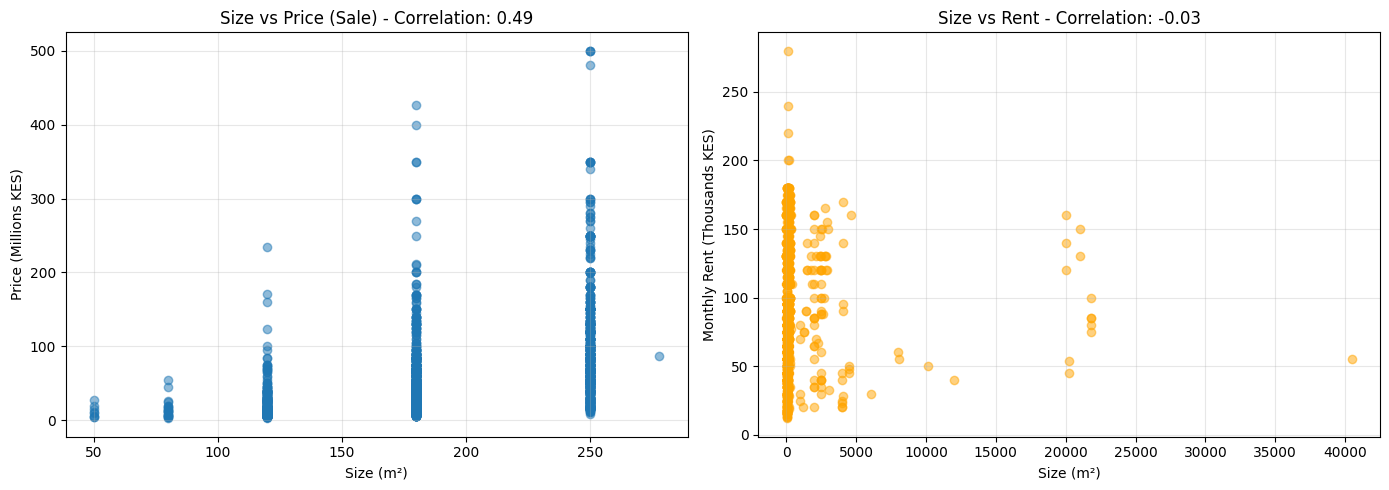

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sale
axes[0].scatter(sale_df['Size_SQM'], sale_df['Price_KES'] / 1_000_000, alpha=0.5)
axes[0].set_xlabel('Size (m²)')
axes[0].set_ylabel('Price (Millions KES)')
axes[0].set_title(f'Size vs Price (Sale) - Correlation: {sale_corr:.2f}')
axes[0].grid(alpha=0.3)

# Rent
axes[1].scatter(rent_df['Size_SQM'], rent_df['Price_KES'] / 1_000, alpha=0.5, color='orange')
axes[1].set_xlabel('Size (m²)')
axes[1].set_ylabel('Monthly Rent (Thousands KES)')
axes[1].set_title(f'Size vs Rent - Correlation: {rent_corr:.2f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()

##### Q3. Which amenities increase value?

In [12]:
print("\nFor Sale Properties:")
sale_by_amenity = sale_df.groupby('Amenity_Score')['Price_KES'].agg(['median', 'count'])
sale_by_amenity = sale_by_amenity[sale_by_amenity['count'] >= 10]
for score, row in sale_by_amenity.iterrows():
    print(f"  Score {score}: KES {row['median']:>15,.0f} ({int(row['count'])} listings)")

# For Rent
print("\nFor Rent Properties:")
rent_by_amenity = rent_df.groupby('Amenity_Score')['Price_KES'].agg(['median', 'count'])
rent_by_amenity = rent_by_amenity[rent_by_amenity['count'] >= 10]
for score, row in rent_by_amenity.iterrows():
    print(f"  Score {score}: KES {row['median']:>12,.0f}/month ({int(row['count'])} listings)")

# Calculating percentage increase from lowest to highest amenity score
if len(sale_by_amenity) > 1:
    low_price = sale_by_amenity.iloc[0]['median']
    high_price = sale_by_amenity.iloc[-1]['median']
    increase = ((high_price - low_price) / low_price) * 100
    print(f"\nPrice increase from lowest to highest amenity score (Sale): {increase:.1f}%")

# Individual amenity analysis
print("\n\nIndividual Amenity Impact (For Sale):")
amenities_to_check = ['Pool', 'Gym', 'Generator', 'Borehole', 'Garden', 'DSQ']

for amenity in amenities_to_check:
    with_amenity = sale_df[sale_df['Amenities'].str.contains(amenity, case=False, na=False)]
    without_amenity = sale_df[~sale_df['Amenities'].str.contains(amenity, case=False, na=False)]
    
    if len(with_amenity) >= 5 and len(without_amenity) >= 5:
        with_median = with_amenity['Price_KES'].median()
        without_median = without_amenity['Price_KES'].median()
        diff = with_median - without_median
        pct_diff = (diff / without_median) * 100
        
        print(f"\n{amenity}:")
        print(f"  With: KES {with_median:>15,.0f} ({len(with_amenity)} listings)")
        print(f"  Without: KES {without_median:>12,.0f} ({len(without_amenity)} listings)")
        print(f"  Difference: +KES {diff:,.0f} (+{pct_diff:.1f}%)")


For Sale Properties:
  Score 2: KES      39,000,000 (1840 listings)

For Rent Properties:
  Score 2: KES       95,000/month (1837 listings)


Individual Amenity Impact (For Sale):


##### Visualizations for the above

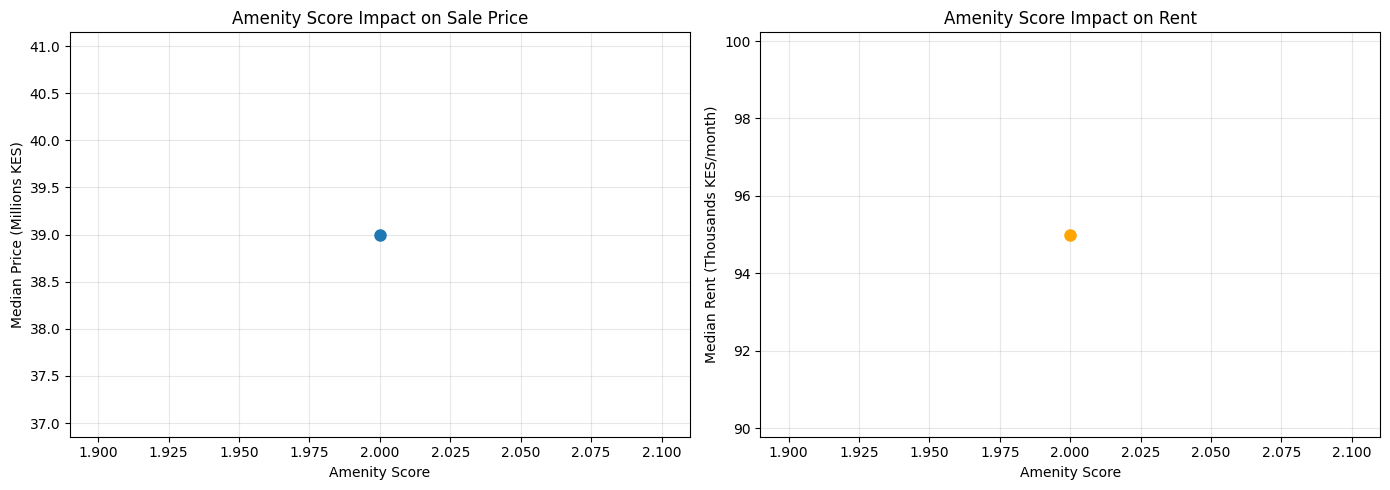

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Amenity score vs price (Sale)
axes[0].plot(sale_by_amenity.index, sale_by_amenity['median'] / 1_000_000, 
             marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Amenity Score')
axes[0].set_ylabel('Median Price (Millions KES)')
axes[0].set_title('Amenity Score Impact on Sale Price')
axes[0].grid(alpha=0.3)

# Amenity score vs rent (Rent)
axes[1].plot(rent_by_amenity.index, rent_by_amenity['median'] / 1_000,
             marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Amenity Score')
axes[1].set_ylabel('Median Rent (Thousands KES/month)')
axes[1].set_title('Amenity Score Impact on Rent')
axes[1].grid(alpha=0.3)

plt.tight_layout()

##### BASELINE MODEL - LINEAR REGRESSION

In [ ]:
## I intend to only use numeric features for the baseline as it'll be hectic to use categorical features. For location I'll use one-hot encoding to create dummy variables to help with the modeling.

features = ['Bedrooms', 'Bathrooms', 'Size_SQM', 'Amenity_Score', 'Distance_to_CBD_KM']

### Here I have one-hot encoded the top 15 locations, the rest I have grouped them as others
sale_model_df = sale_df.copy()
top_locations = sale_df['Location'].value_counts().head(15).index
sale_model_df['Location_Group'] = sale_model_df['Location'].apply(
    lambda x: x if x in top_locations else 'Other'
)

location_dummies = pd.get_dummies(sale_model_df['Location_Group'], prefix='Loc')
property_dummies = pd.get_dummies(sale_model_df['Property_Type'], prefix='Type')

X = pd.concat([
    sale_model_df[features],
    location_dummies,
    property_dummies
], axis=1)

y = sale_model_df['Price_KES']

print(f"\nModel features: {X.shape[1]} total")
print(f"Training samples: {len(X)}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

## Training the model

model = LinearRegression()
model.fit(X_train, y_train)

print("\n✓ Model trained")

## Making Predictions

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluating the model

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)



Model features: 24 total
Training samples: 1840

Train set: 1472 samples
Test set: 368 samples

✓ Model trained


In [ ]:
print("\nMean Absolute Error (MAE):")
print(f"  Train: KES {train_mae:,.0f}")
print(f"  Test:  KES {test_mae:,.0f}")
print(f"\n  → On average, predictions are off by KES {test_mae:,.0f}")
print(f"  → That's about {(test_mae / y_test.mean()) * 100:.1f}% of the average price")

print("\nRoot Mean Squared Error (RMSE):")
print(f"  Train: KES {train_rmse:,.0f}")
print(f"  Test:  KES {test_rmse:,.0f}")

print("\nR² Score (how much variance is explained):")
print(f"  Train: {train_r2:.3f}")
print(f"  Test:  {test_r2:.3f}")

if test_r2 > 0.7:
    print("  → Good model fit")
elif test_r2 > 0.5:
    print("  → Decent model fit, room for improvement")
else:
    print("  → Weak model fit, needs improvement")

# Feature importance (coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nFeatures with largest impact on price:")
for i, row in feature_importance.head(10).iterrows():
    impact = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"{row['Feature']:30s}: {impact} price by KES {abs(row['Coefficient']):>12,.0f}")


Mean Absolute Error (MAE):
  Train: KES 31,177,295
  Test:  KES 31,695,348

  → On average, predictions are off by KES 31,695,348
  → That's about 51.8% of the average price

Root Mean Squared Error (RMSE):
  Train: KES 49,608,301
  Test:  KES 49,314,661

R² Score (how much variance is explained):
  Train: 0.336
  Test:  0.372
  → Weak model fit, needs improvement

TOP 10 MOST IMPORTANT FEATURES

Features with largest impact on price:
Loc_Kitisuru                  : increases price by KES   63,021,238
Loc_Karen                     : increases price by KES   41,395,424
Loc_Westlands                 : decreases price by KES   36,886,609
Loc_Ongata Rongai             : decreases price by KES   33,769,570
Loc_Runda                     : increases price by KES   31,269,683
Loc_Ruiru                     : decreases price by KES   31,114,606
Loc_Ngong                     : decreases price by KES   30,769,089
Loc_Kitengela                 : decreases price by KES   28,344,593
Loc_Nairobi     

##### Visualizations for the above

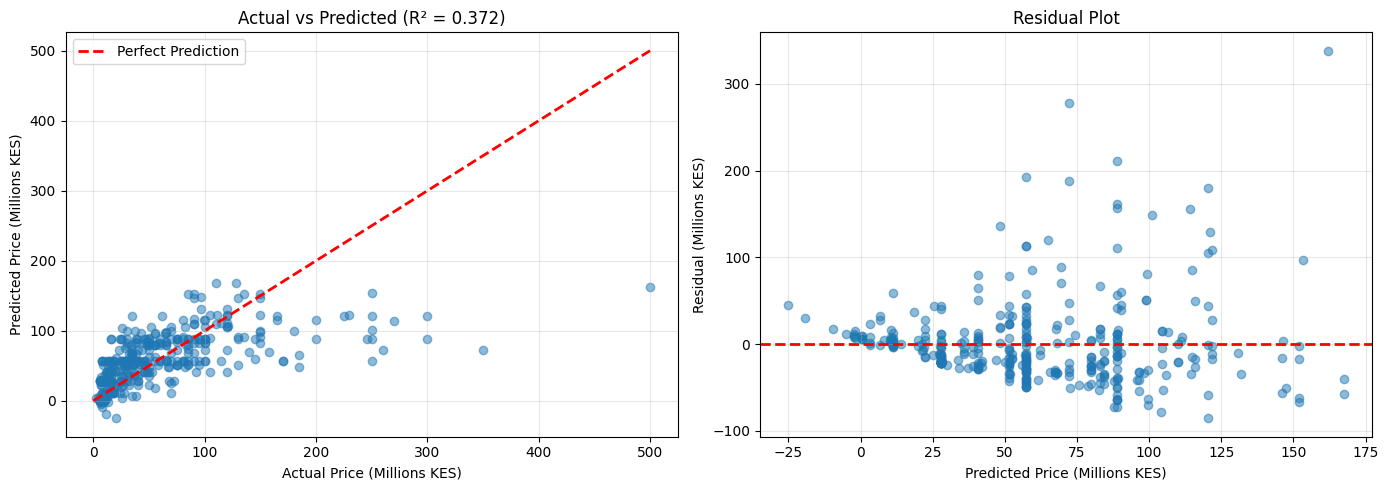

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test / 1_000_000, y_pred_test / 1_000_000, alpha=0.5)
axes[0].plot([0, y_test.max() / 1_000_000], [0, y_test.max() / 1_000_000], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (Millions KES)')
axes[0].set_ylabel('Predicted Price (Millions KES)')
axes[0].set_title(f'Actual vs Predicted (R² = {test_r2:.3f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test / 1_000_000, residuals / 1_000_000, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price (Millions KES)')
axes[1].set_ylabel('Residual (Millions KES)')
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()